In [71]:
import scipy.io.wavfile
import sys
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.lines
from scipy.spatial.distance import hamming
from fastdtw import fastdtw
import librosa
import librosa.display
%matplotlib inline

## Concert

In [74]:
filename = "Taylor_Swift_-_22_STB_2013_.wav"
y, fs = librosa.load(filename)
startTime = (0,24) # (minute, second)
endTime   = (1,0) # (minute, second)

In [58]:
def trim(sig, fs, startTime, endTime):
    startTimeIdx = round((startTime[0] * 60 + startTime[1]) * fs)
    endTimeIdx   = round((endTime[0] * 60 + endTime[1]) * fs)
    
    print("signal shape = {:} frame rate = {:}".format(sig.shape, fs), file=sys.stderr)
    print("startTimeIdx = {:} endTimeIdx = {:}".format(startTimeIdx, endTimeIdx), file=sys.stderr)
    
    return sig[startTimeIdx:endTimeIdx], fs

In [61]:
def generateChunks(sig, fs, chunkLengthSec, verbose=False):
    chunkLengthSize = round(chunkLengthSec * fs)
    
    chunkIdx = 0
    currentEnding = 0
    output = []
    while currentEnding + chunkLengthSize < sig.shape[0]:
        output.append(sig[currentEnding:currentEnding + chunkLengthSize])
        if(verbose): print("[{:3d}] idx = [{:7d},{:7d})".format(chunkIdx, currentEnding, currentEnding + chunkLengthSize), file=sys.stderr)
        chunkIdx += 1
        currentEnding += chunkLengthSize
    
    if(verbose): print("[{:3d}] idx = [{:7d},{:7d})".format(chunkIdx, currentEnding, sig.shape[0]), file=sys.stderr)
    output.append(sig[currentEnding: sig.shape[0]])
    return output

In [75]:
y_new, fs = trim(y, fs, startTime, endTime)

signal shape = (6218384,) frame rate = 22050
startTimeIdx = 529200 endTimeIdx = 1323000


In [76]:
hop_size=1024 
X_1_chroma = librosa.feature.chroma_cqt(y=y_new, sr=fs,
                                        hop_length=hop_size, # number of samples between consecutive frames
                                        n_chroma=12,    # number of chroma bins to produce
                                        )
print(X_1_chroma.shape)

(12, 776)


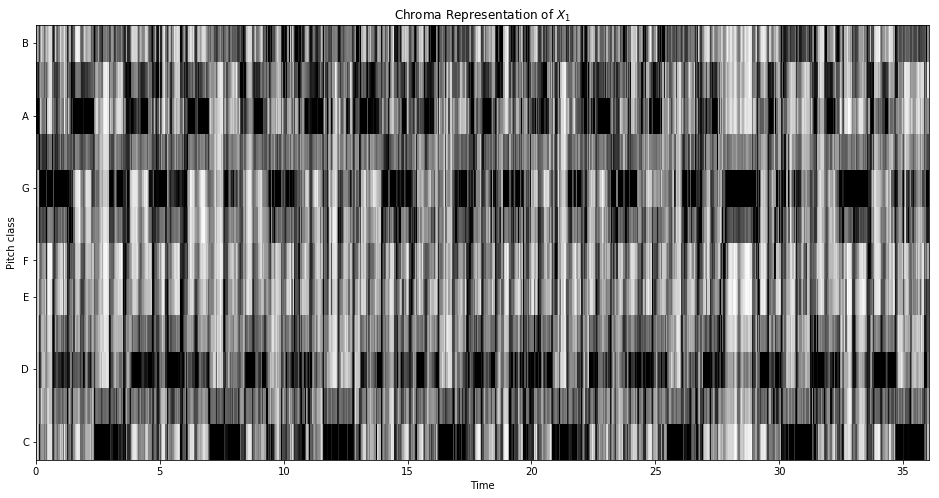

In [77]:
plt.figure(figsize=(16,8))
plt.title("Chroma Representation of $X_1$")
librosa.display.specshow(X_1_chroma, x_axis='time', y_axis='chroma', cmap='gray_r', hop_length=hop_size)

In [62]:
concertTrack = generateChunks(y_new, fs, 6)

## Clean album track

In [83]:
filename = "Taylor_Swift_-_22.wav"
y_original, fs = librosa.load(filename)
startTime = (0,24) # (minute, second)
endTime   = (1,10) # (minute, second)
y_original, fs = trim(y, fs, startTime, endTime)

signal shape = (6218384,) frame rate = 22050
startTimeIdx = 529200 endTimeIdx = 1543500


In [84]:
X_2_chroma = librosa.feature.chroma_cqt(y=y_original, sr=fs,
                                        hop_length=hop_size, # number of samples between consecutive frames
                                        n_chroma=12,    # number of chroma bins to produce
                                        )

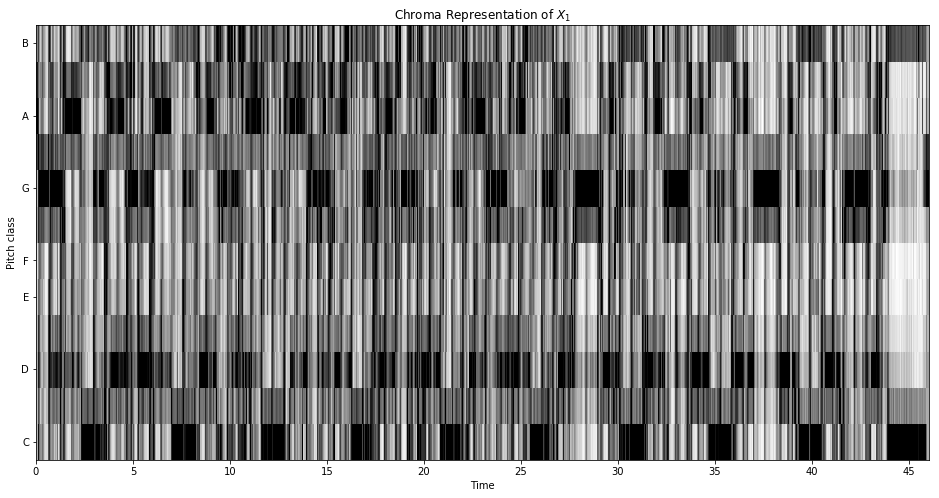

In [85]:
plt.figure(figsize=(16,8))
plt.title("Chroma Representation of $X_1$")
librosa.display.specshow(X_2_chroma, x_axis='time', y_axis='chroma', cmap='gray_r', hop_length=hop_size)

In [86]:
cleanAlbum = generateChunks(y_original, fs, 6)

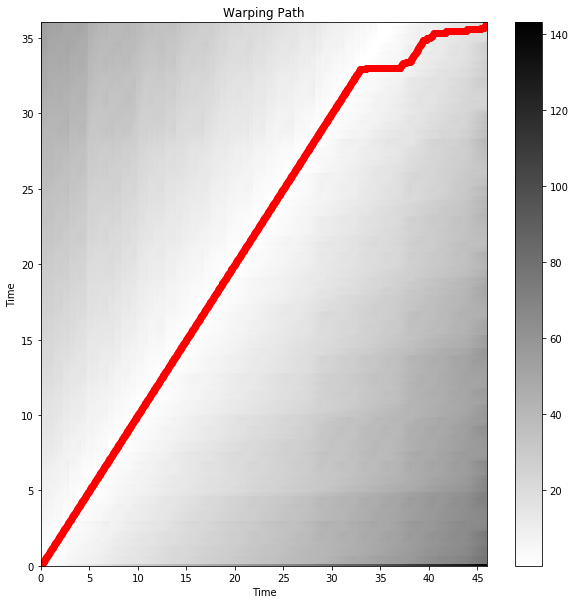

In [87]:
D, wp = librosa.core.dtw(X=X_1_chroma, Y=X_2_chroma, metric='cosine')
wp_s = np.asarray(wp) * hop_size / fs

fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111)
librosa.display.specshow(D, x_axis='time', y_axis='time', cmap='gray_r',
                         hop_length=hop_size)
imax = ax.imshow(D, cmap=plt.get_cmap('gray_r'),
                 origin='lower', interpolation='nearest', aspect='auto')
ax.plot(wp_s[:,1], wp_s[:,0], marker='o', color='red')
plt.title("Warping Path")
plt.colorbar()
plt.show()

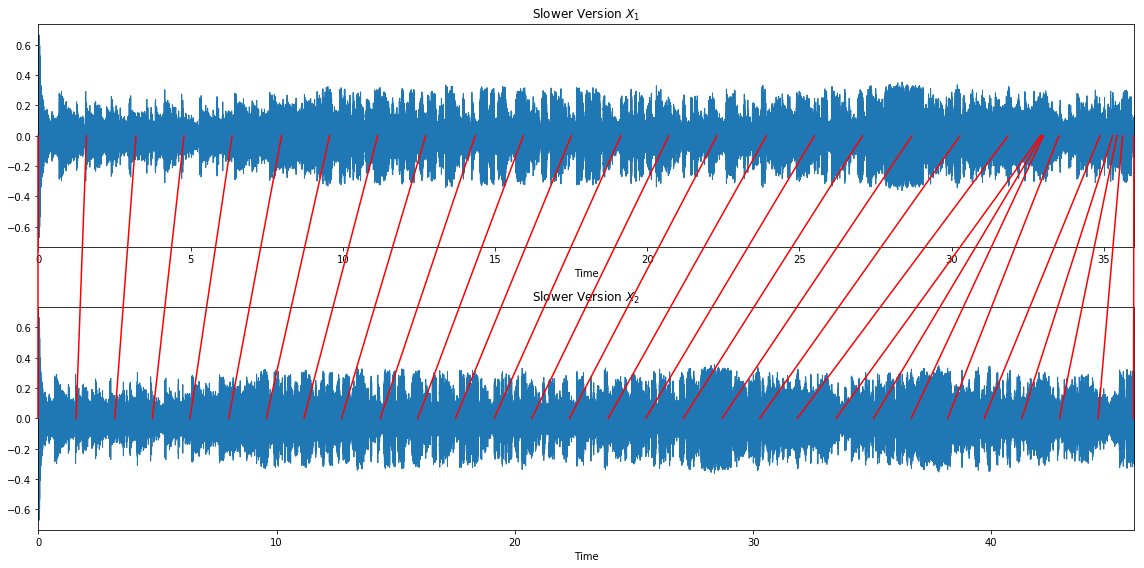

In [88]:
fig = plt.figure(figsize=(16, 8))

# Plot x_1
plt.subplot(2, 1, 1)
librosa.display.waveplot(y_new, sr=fs)
plt.title('Slower Version $X_1$')
ax1 = plt.gca()

# Plot x_2
plt.subplot(2, 1, 2)
librosa.display.waveplot(y_original, sr=fs)
plt.title('Slower Version $X_2$')
ax2 = plt.gca()

plt.tight_layout()

trans_figure = fig.transFigure.inverted()
lines = []
arrows = 30
points_idx = np.int16(np.round(np.linspace(0, wp.shape[0] - 1, arrows)))

# for tp1, tp2 in zip((wp[points_idx, 0]) * hop_size, (wp[points_idx, 1]) * hop_size):
for tp1, tp2 in wp[points_idx] * hop_size / fs:
    # get position on axis for a given index-pair
    coord1 = trans_figure.transform(ax1.transData.transform([tp1, 0]))
    coord2 = trans_figure.transform(ax2.transData.transform([tp2, 0]))

    # draw a line
    line = matplotlib.lines.Line2D((coord1[0], coord2[0]),
                                   (coord1[1], coord2[1]),
                                   transform=fig.transFigure,
                                   color='r')
    lines.append(line)

fig.lines = lines
plt.tight_layout()